# Autoregressive model using a feedforward neural network

In this notebook we will use a feedforward neural network to fit a linear model to time series data. 

<div class="alert alert-success">
    
1. Unlike purpose built time series models such as ARIMA we need to preprocess the data beforehand.

2. Forecasting **h-steps** ahead is more involved than other methods and can use either an iterative, direct (multiple-model) method or vector output methodology.
</div>

---
**LEARNING OBJECTIVES**

* Preprocess time series data to a format compatabile with a feedforward neural network
* Generate h-step forecasts using 
    * an iterative approach
    * a direct modelling approach
    * a vector output layer approach
* Construct a deep feedforward neural network for forecasting
---

> **If you are struggling with the neural network aspects of this notebook then please note there is a Ordinary Least Squares regression version you can explore.  This covers the preprocessing and iterative and direct methods for forecasting.**


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided for this work. We are going to implement neural networks using `tensorflow` and '`keras`. You should be using at least `tensorflow` version `2.1.0`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#tensorflow/keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

#stop TF internal warnings displaying in Jupyter.
import logging
tf.get_logger().setLevel(logging.ERROR)

tf.__version__

2021-12-07 16:52:44.617376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 16:52:44.617410: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.7.0'

## 2. The forecasting process for Feedforward neural networks

1. Select $l$ the number of autoregressive lags and forecast horizon $h$
2. Preprocess the data into tabular form [[$lag_1, lag_2, ... lag_l$], [$y_t$]]
3. Train the NN model using the tabular data
4. Iteratively forecast 1-step ahead gradually replacing ground truth observations with predictions.


### 2.1 Synthetic data without noise

Given the extra complexities of forecasting using OLS we will use simple synthetic data before exploring real healthcare data. The synthetic data we wil use is a cosine.  

In [2]:
t = np.arange(200)
ts_data = np.cos(0.2 * t)

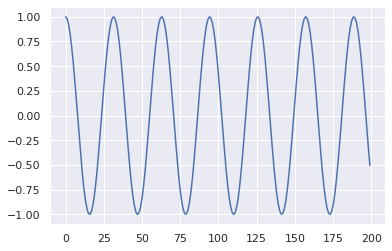

In [3]:
plt.plot(ts_data);

## 2.2. Preprocess the time series into tabular autoregressive form

An autoregressive model consists of $l$ lags of the time series. 

An easy way to think about the form of the data for a autoregressive OLS model is as a table of variables.  The first $l$ columns are the lags (the independent predictor variables) and the final column is $y$ at time $t$ ($y_t$) that is, the target/dependent variable.  

We there need to manipulate the time series so that is now in that format.  More precisely for each row we need: 

**A vector presenting the lags at time t**
* $X_t = $ [$lag_{t-l}, ... lag_{t-2}, lag_{t-1}$]

**A scalar value representing y at time t:**
* $y_t$

For training we need a vector of rows ($X_t$) and vector of target $y_t$. e.g.

```python
X_train = [X_1, X_2, X_3, ...,  X_t]

y_train = [y_1, y_2, y_3, ..., y_t]
```
---

The function `sliding_window` illustrates how to preprocess time series data into tabular form  in python.

In [4]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, )

In [5]:
#preprocess time series training and test sets
X_train, y_train = sliding_window(ts_data, window_size=2)

training_length = int(len(y_train) * (2/3))

X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]
print(X_train.shape, y_train.shape)

(131, 2) (131,)


In [6]:
print(f'ts_data[:3]: {ts_data[:3]}')
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

ts_data[:3]: [1.         0.98006658 0.92106099]
X_train[0]: [1.         0.98006658]
y_train[0]: 0.9210609940028851


In [7]:
print(f'ts_data[1:4]: {ts_data[1:4]}')
print(f'X_train[1]: {X_train[1]}')
print(f'y_train[1]: {y_train[1]}')

ts_data[1:4]: [0.98006658 0.92106099 0.82533561]
X_train[1]: [0.98006658 0.92106099]
y_train[1]: 0.8253356149096782


<div class="alert alert-warning">
    
Just to be absolutely clear what we are doing let's convert the numpy arrays to a **pandas.DataFrame**.  In this format you should be able to see why the a regression model (such an OLS or a feedforward neural network can be used for autoregression in a time series.
</div>


In [8]:
tabular_form = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
columns = [f'lag_{i}' for i in range(len(X_train[0]), 0, -1)]
columns.append('y_t')
tabular_form.columns = columns
tabular_form.head()

,lag_2,lag_1,y_t
0,1.000000,0.980067,0.921061
1,0.980067,0.921061,0.825336
2,0.921061,0.825336,0.696707
3,0.825336,0.696707,0.540302
4,0.696707,0.540302,0.362358


## 2.3 Train the NN using the preprocessed series

After preprocessing the data, fitting the data is relatively straightforward.  We create and compile an instance of a `Keras.models.Sequential` pass in the training data and call the `.fit()` method.  The method fit returns results that can be used to check for overfitting and convergence. 

In [9]:
def get_linear_model(ws, lr=0.01, metrics=None):
    '''
    OLS model implemented as a ff neural netweork
    '''
    if metrics is None:
        metrics = ['mae', 'mse']
    
    model = Sequential([Dense(1, input_shape=(ws,))])
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=lr),
                  metrics=metrics)
    
    return model

In [10]:
N_EPOCHS = 100
WINDOW_SIZE = 5
es = EarlyStopping(monitor='val_loss', patience=2)

#pre-process the data into sliding windows
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train test split
training_length = int(len(y_train) * (2/3))
X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]

#compile the tf model
model = get_linear_model(WINDOW_SIZE)

results = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

2021-12-07 16:52:45.745558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 16:52:45.746058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 16:52:45.746101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-07 16:52:45.746155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-07 16:52:45.746232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

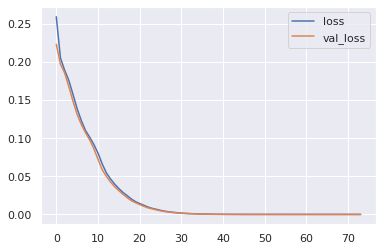

In [11]:
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()

## 2.4 Forecasting 1 step ahead

To forecast 1-step ahead we use treat the network as we would for other regression problems i.e. we call the `.predict()` method.  For example if we wanted to forecast the first y observation in the test set.

In [12]:
X_test[0]

array([0.78552098, 0.64691932, 0.48252703, 0.29889791, 0.10335267])

In [13]:
pred = model.predict(x=X_test[0].reshape(1, -1))[0,0]
print(f'1-step forecast: {pred}')
print(f'ground trust value: {y_test[0]}')

1-step forecast: -0.09631577879190445
ground trust value: -0.09631291684576058


## 2.4 Forecast h periods ahead using the iterative method.

**We have trained our `NN` model to predict 1-step**. When forecasting 2 or more steps ahead we still only have five ground truth observations ($lag_1$ ... $lag_5$). This means that when forecasting h-steps ahead we need to do this in a loop where we iteratively replace our ground truth observations with our predictions.

Let's assume we are forecasting 3 periods ahead and have a model with 5 lags.  

In [14]:
X_1 = [100, 120, 110, 95, 135]
print(f'Input for forecasting t+1 = {X_1}')

Input for forecasting t+1 = [100, 120, 110, 95, 135]


In [15]:
forecast_1 = 111

In [16]:
X_2 = X_1[1:] + [forecast_1] 
print(f'Input for forecasting t+2 = {X_2}')

Input for forecasting t+2 = [120, 110, 95, 135, 111]


In [17]:
forecast_2 = 222

In [18]:
X_3 = X_2[1:] + [forecast_2] 
print(f'Input for forecasting t+3 = {X_3}')

Input for forecasting t+3 = [110, 95, 135, 111, 222]


There's an easy way implemented iterative forecasting in python using the `np.roll(a, shift)` function.  That shifts everything in the array down by `shift`.  The function is **circular** so the value in element 0 is moved to be the final value in the array.

In [19]:
forecast_3 = 999

X_4 = np.roll(X_3, shift=-1)
print(f'after np.roll {X_4}')
X_4[-1] = forecast_3
print(f'after inserting last forecast: {X_4}')

after np.roll [ 95 135 111 222 110]
after inserting last forecast: [ 95 135 111 222 999]


In [20]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        #1 step forecast
        y_pred = model.predict(current_X.reshape(1, -1))[0,0]
        #store prediction
        y_preds.append(y_pred)
        
        #roll the array and insert forecast
        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [21]:
H = 5
y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
print(f'Iterative forecast: {y_preds}')
print(f'Ground truth y: {y_test[:H].T}')

Iterative forecast: [-0.09631578 -0.2921466  -0.47633472 -0.6415374  -0.7811697 ]
Ground truth y: [-0.09631292 -0.29213881 -0.47631805 -0.64150799 -0.78112303]


# Adding some noise

To make this a bit more interesting we will add some normally distributed noise to the synthetic time series.

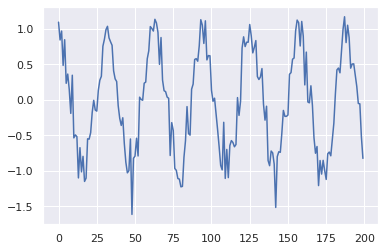

In [22]:
#set the random seed so that we all get the same results
np.random.seed(12)
t = np.arange(200)
ts_data = np.cos(0.2 * t)
noise = np.random.normal(loc=0.0, scale=0.2, size=200)
ts_data = ts_data + noise
plt.plot(ts_data);

In [23]:
#set tensorflow random seed
tf.random.set_seed(1234)

N_EPOCHS = 100
WINDOW_SIZE = 12
es = EarlyStopping(monitor='val_loss', patience=10)

#preprocess time series training and test sets
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

training_length = 130

#train-test split
X_train, X_test = X_train[:training_length], X_train[training_length:]
y_train, y_test = y_train[:training_length], y_train[training_length:]

#compile the tf model
model = get_linear_model(WINDOW_SIZE, metrics=['mse'], lr=0.001)

#fit model silently
results = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

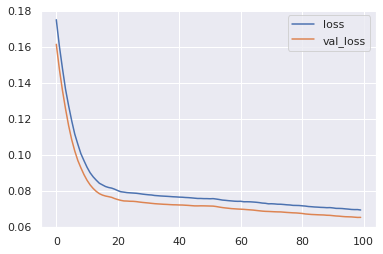

In [24]:
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()

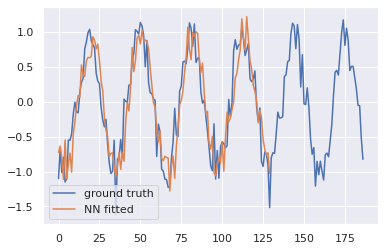

In [25]:
plt.plot(ts_data[WINDOW_SIZE+1:], label='ground truth')
plt.plot(model.predict(X_train), label='NN fitted')
plt.legend();

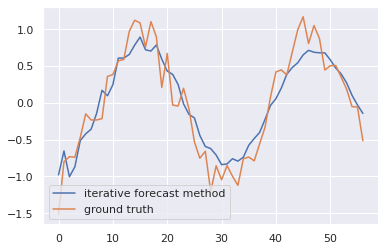

In [26]:
#make iterative predictions
H = len(y_test)
y_preds_iter = autoregressive_iterative_forecast(model, X_test[0], h=H)

#plot
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

##  2.5 The direct h-step forecasting method.

In the direct method to forecast h-steps ahead we have **$h$ forecasting models**.  Each model provides a single point forecast from a step ahead.  In the example here, y_test is of length 57 periods.  The direct method requires 57 NNs to make its prediction!


Recall the `sliding_window` function.  We ignored an optional parameter `horizon` in the iterative example.  By default `horizon=1` i.e. the function returns target values that are only a single period ahead.  We can vary the step size by increasing the value of horizon.  

**Training multiple models**

1. Create a for loop and set it to iterate 57 times. 
2. In each loop call `sliding_window` setting `horizon` to the iteration number + 1
3. Create a new instance of the the model
4. Train the model and save in a list.
5. Save the model to .h5 file. (recommended so you can reload without retraining)

In [27]:
def train_direct_models(data, n_epochs, horizon, window_size, 
                        train_length, save=False):
    models = []

    print('Training model =>', end=' ')
    for h in range(horizon):
        print(f'{h+1}', end=', ')
        #preprocess time series training and test sets
        X_train, y_train = sliding_window(data, 
                                          window_size=window_size, 
                                          horizon=h+1)

        #train-test split
        X_train, X_test = X_train[:train_length], X_train[train_length:]
        y_train, y_test = y_train[:train_length], y_train[train_length:]

        #compile the tf model
        model_h = get_linear_model(window_size, metrics=['mse'], lr=0.001)

    
        #fit model silently (verbose=0)
        results_h = model_h.fit(x=X_train, 
                            y=y_train, 
                            epochs=n_epochs,
                            verbose=0)
        
        if save:
            model_h.save(f'./output/direct_model_h{h+1}.h5')

        models.append(model_h)

    print('done')
    return models

In [28]:
def load_models(horizon):
    '''
    load pre-trained models.
    '''
    models = []
    for h in range(HORIZON):
        model_h = tf.keras.models.load_model(f'output/direct_model_h{h+1}.h5')
        models.append(model_h)
    return models

In [29]:
#set tensorflow random seed
tf.random.set_seed(42)

N_EPOCHS = 100
HORIZON = len(y_test)
WINDOW_SIZE = 12
TRAIN_LENGTH = 130
LOAD_FROM_FILE = False

if LOAD_FROM_FILE:
    direct_models = load_models(HORIZON)
else:
    direct_models = train_direct_models(ts_data, 
                                        n_epochs=N_EPOCHS,
                                        horizon=HORIZON, 
                                        window_size=WINDOW_SIZE, 
                                        train_length=TRAIN_LENGTH)

Training model => 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, done


We now create the `direct_forecast` function.  This is just a for loop to call the `.predict()` method of each model.  Remember that the input to each model is **same** i.e. exog which in our case will be `X_test[0]`

In [30]:
def direct_forecast(models, exog):
    '''
    h-step forecast for an autoregressive 
    model using the direct prediction method.
    
    Each model contained in @models has been trained
    to predict a unique number of steps ahead. 
    Each model forecasts and the results are 
    combined in an ordered array and returned.
    
    Parameters:
    ------
    models: list
        direct models each has has a .predict(exog) 
        interface
        
    exog: array-like
        initial vector of lagged values (X)
        
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    preds = []
    for model_h in models:
        pred_h = model_h.predict(x=exog.reshape(1, -1))[0, 0]
        preds.append(pred_h)
    
    return np.array(preds)

In [31]:
#make the direct forecast
y_preds_direct = direct_forecast(direct_models, X_test[0])

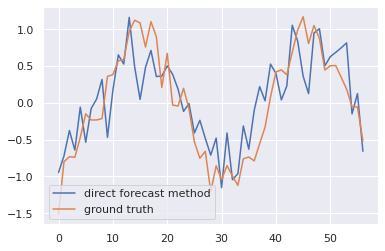

In [32]:
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(ts_data, window_size=WINDOW_SIZE)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

#plot the direct forecast against the test data
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_test, label='ground truth')
plt.legend()

Like the iterative method the direct method looks a close match to the ground truth test set!  Let's plot all three datasets on the same chart and then take a look at the **RMSE** of each method.

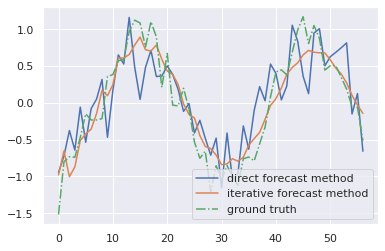

In [33]:
#plot iterative and direct
plt.plot(y_preds_direct, label='direct forecast method')
plt.plot(y_preds_iter, label='iterative forecast method')
plt.plot(y_test, label='ground truth', linestyle='-.')
plt.legend()

In [34]:
from statsmodels.tools.eval_measures import rmse

In [35]:
#rmse iterative method
rmse(y_test, y_preds_iter)

0.25617254807394085

In [36]:
#rmse direct method
rmse(y_test, y_preds_direct)

0.39825222983062186

In this particular example (and single holdout set) the iterative method out performed the direct method. You should not assume this is always the case!

## 2.6 Forecasting a vector of y

In the **iterative** and **direct** methods we always forecast a *scalar* value.  An modification is to adapt a feedforward neural network to predict a **vector of y values**.  Using this architecture we would train our model on sliding windows of $X$ and $y$.  Where y is a vector of length $h$ and $X$ is a vector of length $ws$ (window size)

### 2.6.1 Exercise: preprocessing the time series into vectors of y
Task: modify the function `sliding_window` (provided below) so that it returns a vectors of y.

Hints:
* Assume you are standing at time $t$. With a forecasting horizon of $h$, y would be $[y_{t+1}, y_{t+2}, ... , y_{t+h}]$.
* Array slicing might prove useful:

```python
train = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(train[2:6])
```
```
>> [3 4 5 6]
```

In [37]:
def sliding_window(train, window_size=2, horizon=2):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=2)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        #we use list slicing to return a vector of training for y_train
        y_train = train[i+window_size:i+window_size+horizon]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.array(tabular_y)

**After** you have modified `sliding_window` run the code below to preprocess the time series.

In [38]:
WINDOW_SIZE = 12
HORIZON = 12
TRAIN_LENGTH = 130
#for clarity repeat the preprocessing
X_train, y_train = sliding_window(ts_data, 
                                  window_size=WINDOW_SIZE,
                                  horizon=HORIZON)

#train-test split
X_train, X_test = X_train[:TRAIN_LENGTH], X_train[TRAIN_LENGTH:]
y_train, y_test = y_train[:TRAIN_LENGTH], y_train[TRAIN_LENGTH:]

In [39]:
y_train.shape

(130, 12)

## 2.6.2 Build setup a model that predicts vectors in Keras

In [40]:
def get_target_vector_network_model(ws, n_inputs, outputs, n_neurons=32,
                                    lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mse']
        
    model = Sequential()
    model.add(Input(shape=(ws,)))
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(outputs))
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=lr),
                  metrics=metrics)
    return model

### 2.6.3 Train the model

In [41]:
#set tensorflow random seed
tf.random.set_seed(1234)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#compile the tf model
model_v = get_target_vector_network_model(WINDOW_SIZE, 
                                          n_inputs=len(y_train),
                                          outputs=HORIZON,
                                          metrics=['mse'])

#fit the model
results_v = model_v.fit(x=X_train, 
                        y=y_train, 
                        epochs=N_EPOCHS,
                        validation_data=(X_test, y_test),
                        verbose=0,
                        callbacks=[es])

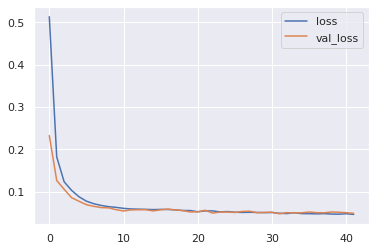

In [42]:
plt.plot(results_v.history['loss'], label='loss')
plt.plot(results_v.history['val_loss'], label='val_loss')
plt.legend()

### 2.6.4 Predict a single vector ahead.

Predicting a single vector ahead is actually making a h-step forecast.  This is done in exactly the same way as the other models using `.predict(X)`

In [43]:
#to understand why we include [0] on the end comment it out and rerun the code.
y_preds = model_v.predict(X_test[0].reshape(1, -1))[0]
y_preds

array([-0.8960362 , -0.6455047 , -0.846195  , -0.6233536 , -0.46215776,
       -0.34998792, -0.22721821, -0.16031946, -0.01902489,  0.15180007,
        0.43134367,  0.6181806 ], dtype=float32)

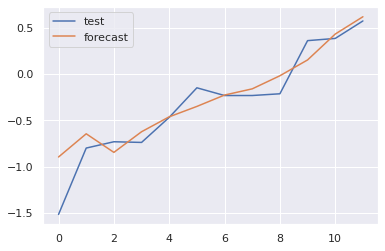

In [44]:
#plot the prediction
plt.plot(y_test[0], label='test')
plt.plot(y_preds, label='forecast')
plt.legend()

### 2.6.5 Exercise predicting multiple vectors ahead (> h-steps)

It is important to remember that with the vector output you predict in multiples of $h$.  So if you make two predictions you have predictions for 2h.  But in general this works in the same way as the iterative method.  Each time you forecast you replace $h$ values in the X vector with the predictions.

**Task**: 
* Modify `autoregressive_iterative_forecast` (provided below) so that it works with the new model.  After you are done rename the function `vector_iterative_forecast`
* Predict 4 vector lengths ahead and plot the result against the test set.

Hints:

* For simplicity, you could make the parameter `h` the number of vectors ahead to predict.
* Each call of `model.predict(X)` returns a vector.  At the end of the iterative forecast you will have a list of vectors.  Call `np.concatenate(list)` to transform this into a single list.
* In the notebook the X and vectors are both of size 12 (`WINDOW_SIZE == 12` and `len(y_train[0]) == 12`). This means you could simplify your code for the example.  Alternatively it could work with different sized X and y vectors. 
* Remember that `y_test` contains sliding windows of size 12.  So if you predict 2 vectors ahead then you will need to plot `y_test[0]` and `y_test[12]`




In [45]:
def vector_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Assumes that h is less than or equal to the length of 
    exog
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X.reshape(1, -1))[0]
        y_preds.append(y_pred)
        
        #update the input array for the iterative prediction
        v_len = len(y_pred)
        current_X = np.roll(current_X, shift=-v_len)
        current_X[-v_len:] = y_pred.copy()
        
    return np.concatenate(np.array(y_preds))

In [46]:
H=4
y_preds = vector_iterative_forecast(model_v, X_test[0], H)
y_preds.shape

(48,)

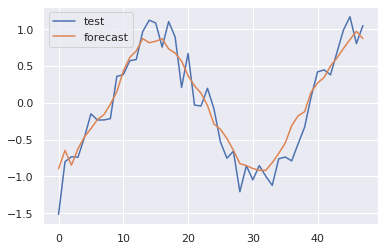

In [47]:
y_test_to_plot = []
for i in range(H):
    y_test_to_plot.append(y_test[WINDOW_SIZE*i])

plt.plot(np.concatenate(y_test_to_plot), label='test')
plt.plot(y_preds, label='forecast')
plt.legend()